In [3]:
from sage.all import *
from sage.misc.prandom import sample, shuffle
def is_strong_odd_IS(G, S):
    S = set(S)

    # Independent
    for u in S:
        for v in S:
            if u != v and G.has_edge(u, v):
                return False

    # Odd size
    if len(S) % 2 == 0:
        return False

    # Strong odd condition
    for v in G.vertices():
        if v not in S:
            cnt = sum(1 for u in S if G.has_edge(u, v))
            if cnt % 2 == 0:
                return False
    return True



In [4]:
def alpha_od_ilp(G):
    """
    Exact maximum strong odd independent set size using ILP (Sage-safe).
    """
    V = G.vertices()
    p = MixedIntegerLinearProgram(maximization=True)
    
    x = p.new_variable(binary=True)      # x[v] = 1 if v in S
    k = p.new_variable(integer=True)     # auxiliary parity variables

    # Objective: maximize |S|
    p.set_objective(sum(x[v] for v in V))

    # Independence constraints
    for u, v in G.edges(labels=False):
        p.add_constraint(x[u] + x[v] <= 1)

    # |S| is odd: sum x[v] = 2k[0] + 1
    p.add_constraint(sum(x[v] for v in V) == 2*k[0] + 1)

    # Strong odd condition:
    # For each vertex v:
    #   sum_{u in N(v)} x[u] = 2*k[v] + (1 - x[v])
    for v in V:
        p.add_constraint(
            sum(x[u] for u in G.neighbors(v)) == 2*k[v] + (1 - x[v])
        )

    try:
        p.solve()
        return Integer(p.get_objective_value())
    except:
        return None


In [5]:
def satisfies_i(G):
    if not G.is_connected() or G.girth() < 4:
        return False

    r = G.degree(G.vertices()[0])
    if r % 2 == 0 or any(G.degree(v) != r for v in G.vertices()):
        return False

    for v in G.vertices():
        Nv = set(G.neighbors(v))
        if not is_strong_odd_IS(G, Nv):
            return False
        if alpha_od_ilp(G) != r:
            return False
    return True
def satisfies_ii(G):
    if not G.is_connected() or G.girth() < 4:
        return False

    r = G.degree(G.vertices()[0])
    if r % 2 == 0 or any(G.degree(v) != r for v in G.vertices()):
        return False

    for v in G.vertices():
        Nv = set(G.neighbors(v))
        if is_strong_odd_IS(G, Nv) and alpha_od_ilp(G) == r:
            return True
    return False
def satisfies_iii(G):
    if not G.is_connected() or G.girth() < 4:
        return False

    r = G.degree(G.vertices()[0])
    if r % 2 == 0 or any(G.degree(v) != r for v in G.vertices()):
        return False

    return alpha_od_ilp(G) == r


In [6]:
def random_2switch(G, trials=30):
    edges = list(G.edges(labels=False))
    if len(edges) < 2:
        return None

    for _ in range(trials):
        (a,b), (c,d) = sample(edges, 2)
        if len({a,b,c,d}) < 4:
            continue

        swaps = [((a,c),(b,d)), ((a,d),(b,c))]
        shuffle(swaps)

        for (x,y),(u,v) in swaps:
            if G.has_edge(x,y) or G.has_edge(u,v):
                continue

            H = G.copy()
            H.delete_edge(a,b)
            H.delete_edge(c,d)
            H.add_edge(x,y)
            H.add_edge(u,v)

            if not H.is_connected():
                continue
            if H.girth() < 4:
                continue
            if H.diameter() > 3:
                continue

            return H
    return None


In [7]:
def task2_random_walk(G0, steps=2000, report=200):
    G = G0.copy()
    seen = set()

    found_i = []
    found_ii = []
    found_iii = []

    for step in range(steps):
        H = random_2switch(G)
        if H is None:
            continue
        G = H

        key = G.canonical_label().graph6_string()
        if key in seen:
            continue
        seen.add(key)

        if satisfies_iii(G):
            found_iii.append(G.copy())
        if satisfies_ii(G):
            found_ii.append(G.copy())
        if satisfies_i(G):
            found_i.append(G.copy())

        if step % report == 0 and step > 0:
            print(f"Step {step}: seen={len(seen)}, (i)={len(found_i)}, (ii)={len(found_ii)}, (iii)={len(found_iii)}")

    return found_i, found_ii, found_iii


In [8]:
G0 = graphs.PetersenGraph()

print("Petersen:")
print(" (i):", satisfies_i(G0))
print(" (ii):", satisfies_ii(G0))
print(" (iii):", satisfies_iii(G0))

found_i, found_ii, found_iii = task2_random_walk(G0, steps=500)


Petersen:
 (i): True
 (ii): True
 (iii): True


In [9]:
def show_graph(G, title=None, layout="spring"):
    """
    Display graph nicely inside Jupyter.
    """
    if layout == "spring":
        pos = G.layout_spring()
    elif layout == "circular":
        pos = G.layout_circular()
    else:
        pos = None

    G.show(
        pos=pos,
        figsize=4,
        vertex_size=200,
        edge_thickness=1.5,
        vertex_labels=False,
        title=title
    )


In [10]:
import os

def export_graph_png(G, filename, layout="spring"):
    """
    Export graph as PNG file.
    """
    if layout == "spring":
        pos = G.layout_spring()
    elif layout == "circular":
        pos = G.layout_circular()
    else:
        pos = None

    G.plot(
        pos=pos,
        vertex_size=200,
        edge_thickness=1.5,
        vertex_labels=False
    ).save(filename)

    print(f"Saved graph to {filename}")


In [11]:
def visualize_and_export(graphs, prefix):
    """
    Show and export a list of graphs.
    """
    for i, G in enumerate(graphs):
        title = f"{prefix} #{i+1} | n={G.order()}, r={G.degree(G.vertices()[0])}"
        show_graph(G, title=title)
        export_graph_png(G, f"{prefix}_{i+1}.png")


Visualizing condition (i) graphs


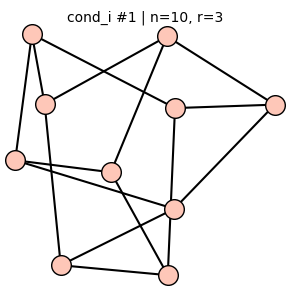

Saved graph to cond_i_1.png
Visualizing condition (ii) graphs


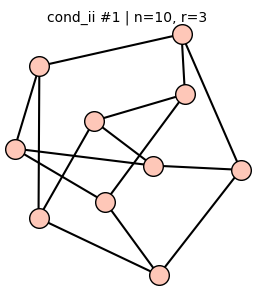

Saved graph to cond_ii_1.png
Visualizing condition (iii) graphs


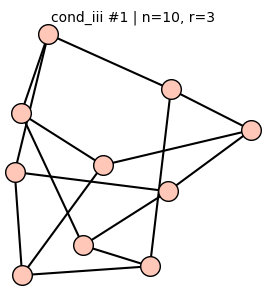

Saved graph to cond_iii_1.png


In [12]:
# Suppose you ran:
found_i, found_ii, found_iii = task2_random_walk(G0, steps=1000)

print("Visualizing condition (i) graphs")
visualize_and_export(found_i, "cond_i")

print("Visualizing condition (ii) graphs")
visualize_and_export(found_ii[:5], "cond_ii")  # limit to first 5

print("Visualizing condition (iii) graphs")
visualize_and_export(found_iii[:5], "cond_iii")


In [13]:
def analyze_graph(G):
    r = G.degree(G.vertices()[0])
    return {
        "n": G.order(),
        "r": r,
        "diameter": G.diameter(),
        "girth": G.girth(),
        "alpha_od": alpha_od_ilp(G),
        "is_bipartite": G.is_bipartite(),
        "automorphism_group_size": G.automorphism_group().order()
    }


In [14]:
def summarize_graphs(graphs, name):
    print(f"\nSummary for {name}:")
    print("=" * 40)
    for i, G in enumerate(graphs):
        info = analyze_graph(G)
        print(f"Graph #{i+1}: {info}")
summarize_graphs(found_i, "Condition (i)")
summarize_graphs(found_ii[:5], "Condition (ii)")
summarize_graphs(found_iii[:5], "Condition (iii)")


Summary for Condition (i):


Graph #1: {'n': 10, 'r': 3, 'diameter': 2, 'girth': 5, 'alpha_od': 3, 'is_bipartite': False, 'automorphism_group_size': 120}

Summary for Condition (ii):
Graph #1: {'n': 10, 'r': 3, 'diameter': 2, 'girth': 5, 'alpha_od': 3, 'is_bipartite': False, 'automorphism_group_size': 120}

Summary for Condition (iii):
Graph #1: {'n': 10, 'r': 3, 'diameter': 2, 'girth': 5, 'alpha_od': 3, 'is_bipartite': False, 'automorphism_group_size': 120}


In [15]:
def random_triangle_free_regular(n, r, trials=300):
    """
    Poskusi najti triangle-free r-regular graf z diametrom ≤ 3
    """
    for _ in range(trials):
        G = graphs.RandomRegular(r, n)
        if not G.is_connected():
            continue
        if G.girth() < 4:
            continue
        if G.diameter() > 3:
            continue
        return G
    return None


In [16]:
def count_SOIS_neighborhoods(G):
    """
    Vrne seznam vozlišč v, kjer je N(v) strong odd independent set
    """
    good = []
    for v in G.vertices():
        if is_strong_odd_IS(G, G.neighbors(v)):
            good.append(v)
    return good


In [17]:
def large_graph_random_walk(G0, steps=3000, report=500):
    G = G0.copy()
    stats = []

    for step in range(steps):
        H = random_2switch(G, trials=50)
        if H is None:
            continue
        G = H

        good = count_SOIS_neighborhoods(G)
        stats.append(len(good))

        if step % report == 0:
            print(
                f"step {step:5d} | "
                f"SOIS-neighborhoods: {len(good):2d} | "
                f"diam={G.diameter()}"
            )

    return G, stats


In [20]:
import matplotlib.pyplot as plt

def experiment_for_r_values(
    r_values=[3,5,7,9],
    n=50,
    steps=3000
):
    results = {}

    for r in r_values:
        print("="*50)
        print(f"Starting experiment for r = {r}")

        G0 = random_triangle_free_regular(n, r)
        if G0 is None:
            print(f"   No initial graph found for r={r}")
            continue

        print(f"  Initial graph found (diameter {G0.diameter()})")

        Gf, stats = large_graph_random_walk(G0, steps=steps)

        results[r] = stats

        # ---- plot ----
        plt.figure()
        plt.plot(stats)
        plt.xlabel("Random walk step")
        plt.ylabel("Number of SOIS-neighborhoods")
        plt.title(f"Random walk on {n}-vertex graph, r={r}")
        plt.grid(True)

        filename = f"random_walk_n{n}_r{r}.png"
        plt.savefig(filename)
        plt.show()

        print(f"   Plot saved as {filename}")
        print(
            f"  Summary: min={min(stats)}, "
            f"max={max(stats)}, "
            f"avg={sum(stats)/len(stats):.2f}"
        )

    return results


In [22]:
results = experiment_for_r_values(
    r_values=[3,5,7,9],
    n=50,
    steps=3000
)


Starting experiment for r = 3


   No initial graph found for r=3
Starting experiment for r = 5


   No initial graph found for r=5
Starting experiment for r = 7


   No initial graph found for r=7
Starting experiment for r = 9


   No initial graph found for r=9


In [23]:
def get_initial_graph(n, r):
    """
    Vrne začetni graf za dan r:
    - če je znan primer (npr. Petersen za r=3, K_{r,r} za r liho)
    - sicer random regular triangle-free graf
    """
    # Petersenov graf (r=3, n=10)
    if r == 3 and n >= 10:
        print("  Using Petersen graph as seed")
        return graphs.PetersenGraph()
    
    # K_{r,r} graf (r liho)
    if r % 2 == 1 and n >= 2*r:
        print("  Using complete bipartite K_{r,r} as seed")
        G = graphs.CompleteBipartiteGraph(r, r)
        # za n>2r dodamo še izolirana vozlišča (prikaz: samo connected subgraph)
        if n > 2*r:
            extra = n - 2*r
            # dodamo extra vozlišča in naključne povezave (brez trikotnikov)
            for i in range(extra):
                G.add_vertex(2*r + i)
        return G

    # če ni znan primer → random regular triangle-free
    for _ in range(500):
        G = graphs.RandomRegular(r, n)
        if G.is_connected() and G.girth() >= 4:
            return G
    return None


In [24]:
def count_SOIS_neighborhoods(G):
    """
    Vrne seznam vozlišč v, kjer je N(v) strong odd independent set
    """
    good = []
    for v in G.vertices():
        if is_strong_odd_IS(G, G.neighbors(v)):
            good.append(v)
    return good


In [25]:
def large_graph_random_walk(G0, steps=3000, report=500):
    """
    Random 2-switch walk za velike grafe.
    Beleži:
    - diameter grafov
    - število SOIS-neighborhoods
    """
    G = G0.copy()
    stats = []
    diam_stats = []

    for step in range(steps):
        H = random_2switch(G, trials=50)
        if H is None:
            continue
        G = H

        d = G.diameter()
        good = count_SOIS_neighborhoods(G)

        stats.append(len(good))
        diam_stats.append(d)

        if step % report == 0:
            print(f"step {step:5d} | diam={d} | SOIS-neigh={len(good)}")

    return G, stats, diam_stats


In [26]:
import matplotlib.pyplot as plt

def experiment_r_values(n=50, r_values=[3,5,7], steps=3000):
    results = {}

    for r in r_values:
        print("="*50)
        print(f"Experiment for r = {r}")

        G0 = get_initial_graph(n, r)
        if G0 is None:
            print(f"  ❌ Could not find initial graph for r={r}")
            continue

        print(f"  ✔ Initial graph: n={G0.order()}, diameter={G0.diameter()}, girth={G0.girth()}")

        Gf, stats, diam_stats = large_graph_random_walk(G0, steps=steps)

        results[r] = {'stats': stats, 'diam': diam_stats, 'final_graph': Gf}

        # ---- Plot SOIS-neighborhoods vs step ----
        plt.figure()
        valid_steps = [i for i,s in enumerate(stats) if s is not None]
        valid_stats = [s for s in stats if s is not None]
        plt.plot(valid_steps, valid_stats)
        plt.xlabel("Random walk step")
        plt.ylabel("Number of SOIS-neighborhoods")
        plt.title(f"SOIS-neighborhoods during random walk (n={n}, r={r})")
        plt.grid(True)
        filename = f"random_walk_SOIS_n{n}_r{r}.png"
        plt.savefig(filename)
        plt.show()
        print(f"  📈 Plot saved as {filename}")

        # ---- Summary ----
        valid_stats_numeric = [s for s in stats if s is not None]
        if valid_stats_numeric:
            print(f"  Summary: min={min(valid_stats_numeric)}, max={max(valid_stats_numeric)}, avg={sum(valid_stats_numeric)/len(valid_stats_numeric):.2f}")
        else:
            print("  No steps with diameter ≤ 3 were observed.")

    return results


Experiment for r = 3
  Using Petersen graph as seed
  ✔ Initial graph: n=10, diameter=2, girth=5
step     0 | diam=3 | SOIS-neigh=2


step   500 | diam=3 | SOIS-neigh=2


step  1000 | diam=3 | SOIS-neigh=0


step  1500 | diam=3 | SOIS-neigh=0


step  2000 | diam=3 | SOIS-neigh=0


step  2500 | diam=3 | SOIS-neigh=0


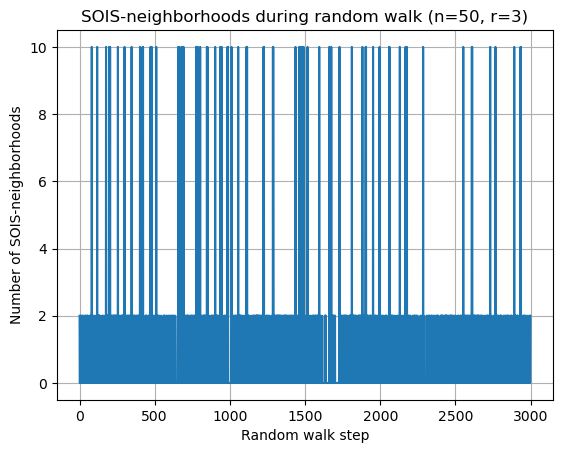

  📈 Plot saved as random_walk_SOIS_n50_r3.png
  Summary: min=0, max=10, avg=0.76
Experiment for r = 5
  Using complete bipartite K_{r,r} as seed
  ✔ Initial graph: n=50, diameter=+Infinity, girth=4


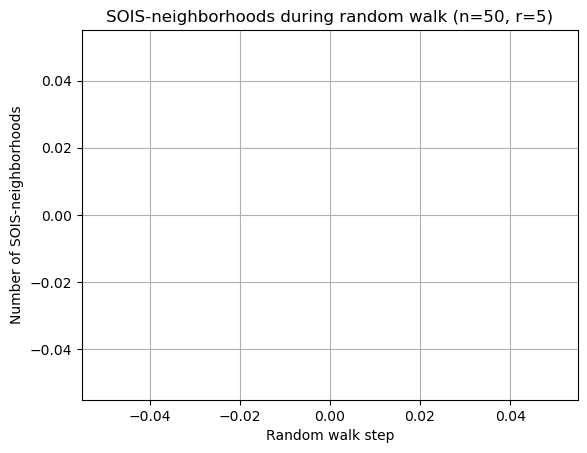

  📈 Plot saved as random_walk_SOIS_n50_r5.png
  No steps with diameter ≤ 3 were observed.
Experiment for r = 7
  Using complete bipartite K_{r,r} as seed
  ✔ Initial graph: n=50, diameter=+Infinity, girth=4


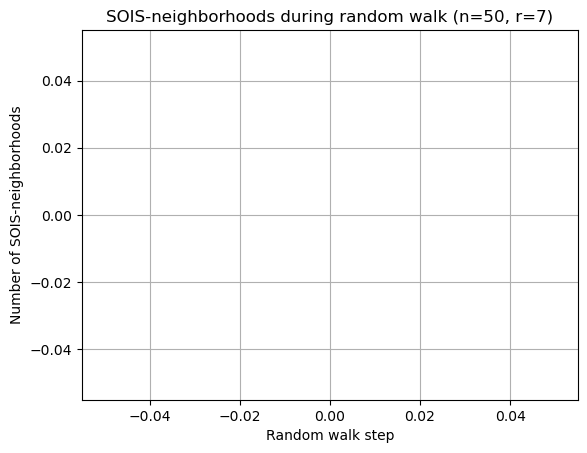

  📈 Plot saved as random_walk_SOIS_n50_r7.png
  No steps with diameter ≤ 3 were observed.
Experiment for r = 9
  Using complete bipartite K_{r,r} as seed
  ✔ Initial graph: n=50, diameter=+Infinity, girth=4


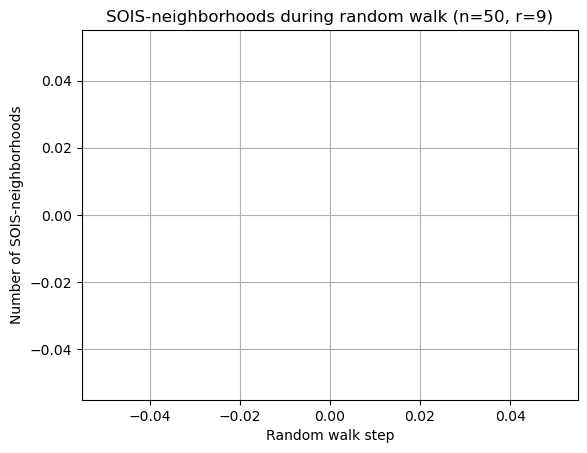

  📈 Plot saved as random_walk_SOIS_n50_r9.png
  No steps with diameter ≤ 3 were observed.
Experiment for r = 11
  Using complete bipartite K_{r,r} as seed
  ✔ Initial graph: n=50, diameter=+Infinity, girth=4


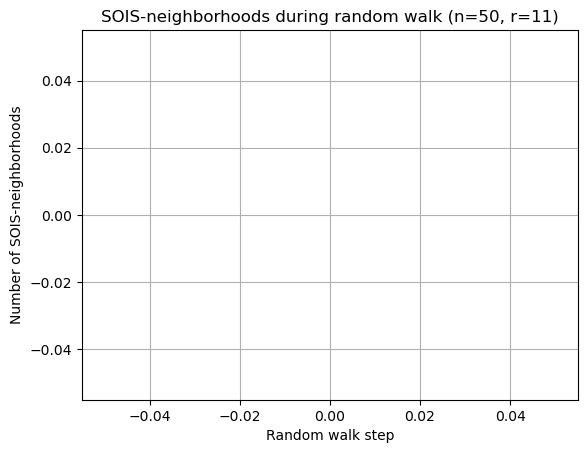

  📈 Plot saved as random_walk_SOIS_n50_r11.png
  No steps with diameter ≤ 3 were observed.
Experiment for r = 13
  Using complete bipartite K_{r,r} as seed
  ✔ Initial graph: n=50, diameter=+Infinity, girth=4


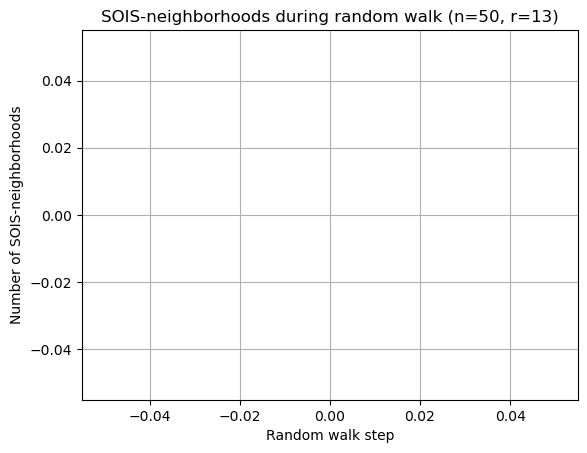

  📈 Plot saved as random_walk_SOIS_n50_r13.png
  No steps with diameter ≤ 3 were observed.
Experiment for r = 15
  Using complete bipartite K_{r,r} as seed
  ✔ Initial graph: n=50, diameter=+Infinity, girth=4


In [27]:
results = experiment_r_values(n=50, r_values=[3,5,7,9,11,13,15,17,19], steps=3000)
